<a href="https://colab.research.google.com/github/yukyu30/suzuri_workshop_20240428/blob/main/suzuri_stability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stability AIとSUZURI　APIを使ってグッズをつくろう
## 必要なもの
- Googleアカウント
- SUZURIのアカウント
- Stability APIのAPIキー

## ワークショップの内容
写真や画像をStablity AIのImage To Image機能を使い、加工してもらい、そのままSUZURIでグッズにします！

In [ ]:
# @title 必要なライブラリのインストール
from io import BytesIO
import IPython
import json
import os
from PIL import Image
import requests
import time
from google.colab import output
import base64

In [ ]:
# @title Stability APIを使う設定をします

import getpass
# @markdown 実行ボタンをクリックして、表示されるフォームに共有されたAPIキーを貼り付けてください
STABILITY_KEY = getpass.getpass('Stability API キーを入力してください')


Stability API キーを入力してください··········


In [ ]:
# @title SUZURI　APIの設定をします

import getpass
# @markdown 実行ボタンをクリックして、表示されるフォームにSUZURI APIキーを貼り付けてください
# @markdown
# @markdown - https://suzuri.jp/developer/apps
SUZURI_KEY = getpass.getpass('SUZURI APIキーを入力してください')


SUZURI APIキーを入力してください··········


In [ ]:
# @title 関数の定義

def send_generation_request(
    host,
    params,
):
    headers = {
        "Accept": "image/*",
        "Authorization": f"Bearer {STABILITY_KEY}"
    }

    # Encode parameters
    files = {}
    image = params.pop("image", None)
    mask = params.pop("mask", None)
    if image is not None and image != '':
        files["image"] = open(image, 'rb')
    if mask is not None and mask != '':
        files["mask"] = open(mask, 'rb')
    if len(files)==0:
        files["none"] = ''

    # Send request
    print(f"Sending REST request to {host}...")
    response = requests.post(
        host,
        headers=headers,
        files=files,
        data=params
    )
    if not response.ok:
        raise Exception(f"HTTP {response.status_code}: {response.text}")

    return response

def creata_product(host, params):

    headers = {
        "Content-Type": "application/json",
        "Authorization": f"Bearer {SUZURI_KEY}"
    }

    response = requests.post(host, data=params, headers=headers)

    return response

画像を生成するための処理を追加しました

# 生成に関して


- SD3：画像生成に6.5クレジットを使用します。
- SD3 Turbo:  画像生成に4クレジットを使用します。

# AIに画像の加工をしてもらう

# Image to Image

Sending REST request to https://api.stability.ai/v2beta/stable-image/generate/sd3...
Saved image generated_1877984330.jpeg


<IPython.core.display.Javascript object>

Result image:


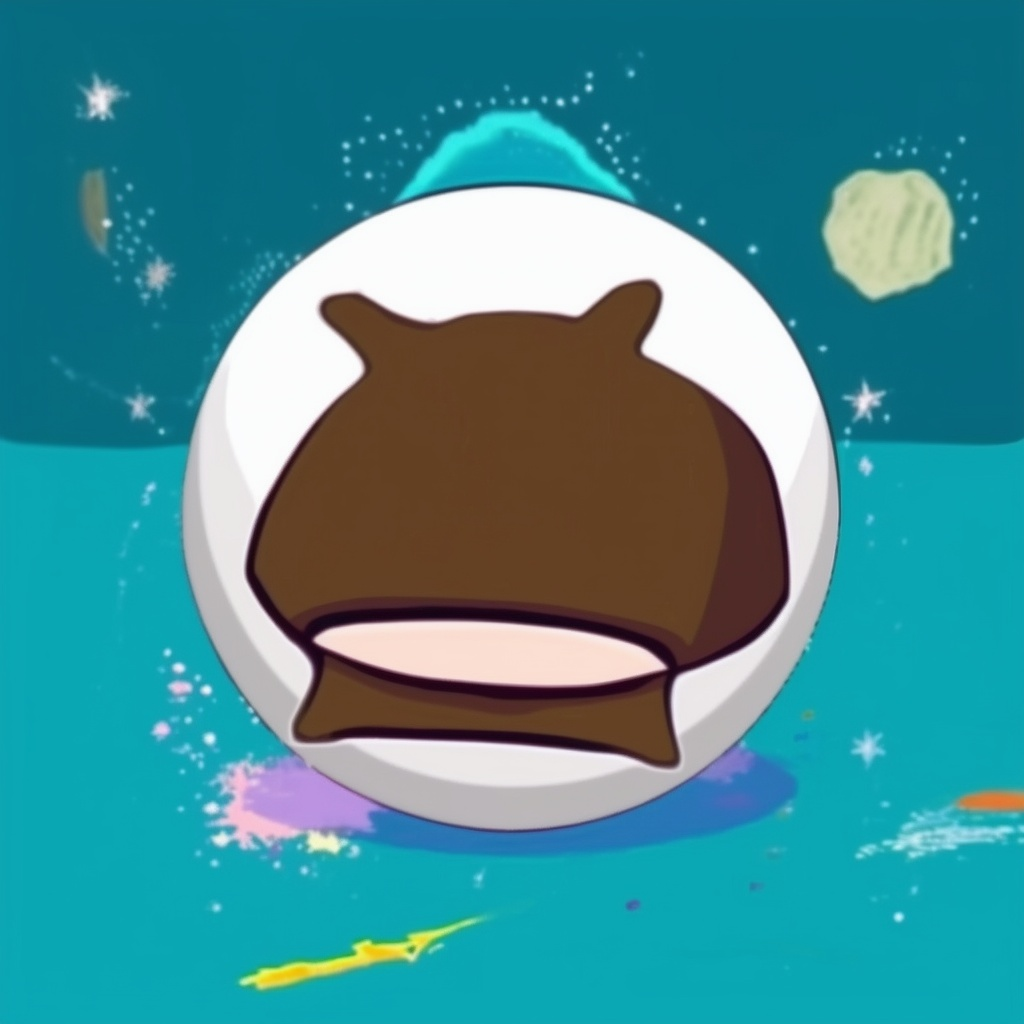

In [ ]:
#@title SD3
#@markdown - 左のフォルダマークをクリックして画像をドラッグアンドドロップ (またはファイルアップロードボタンから画像を追加)
#@markdown - アップロードした画像を左クリックして「パスのコピー」をクリック
#@markdown - imageのフォームにコピーしたパスをペースト
#@markdown - promptのフォームは英語で入力してください(例: convert pixel art)
#@markdown <br><br>

image = "/render.png" #@param {type:"string"}
prompt = "painting art" #@param {type:"string"}
negative_prompt = "" #@param {type:"string"}
seed = 0 #@param {type:"integer"}
output_format = "jpeg" #@param ["jpeg", "png"]
strength = 0.75 #@param {type:"slider", min:0.0, max: 1.0, step: 0.01}

host = f"https://api.stability.ai/v2beta/stable-image/generate/sd3"

params = {
    "image" : image,
    "prompt" : prompt,
    "negative_prompt" : negative_prompt,
    "strength" : strength,
    "seed" : seed,
    "output_format": output_format,
    "mode" : "image-to-image"
}

#　画像加工の実行
response = send_generation_request(
    host,
    params
)

# 加工結果を取得する
output_image = response.content
finish_reason = response.headers.get("finish-reason")
seed = response.headers.get("seed")

# Check for NSFW classification
if finish_reason == 'CONTENT_FILTERED':
    raise Warning("Generation failed NSFW classifier")

# Save and display result
generated = f"generated_{seed}.{output_format}"
with open(generated, "wb") as f:
    f.write(output_image)
print(f"Saved image {generated}")

output.no_vertical_scroll()
print("Result image:")
IPython.display.display(Image.open(generated))


In [ ]:
 #@title SD3
#@markdown - 左のフォルダマークをクリックして画像をドラッグアンドドロップ (またはファイルアップロードボタンから画像を追加)
#@markdown - アップロードした画像を左クリックして「パスのコピー」をクリック
#@markdown - imageのフォームにコピーしたパスをペースト
#@markdown - promptのフォームは英語で入力してください(例: convert pixel art)
#@markdown <br><br>

title = "無題" #@param {type:"string"}
public = True #@param {type:"boolean"}
toribun = 0 #@param {type:"number"}

suzuri_host = f"https://suzuri.jp/api/v1/materials"

# 画像をbase64エンコード

with open(generated, "rb") as image_file:
    # 画像ファイルの中身を読み込む
    image_data = image_file.read()
    # base64にエンコードする
    base64_image = base64.b64encode(image_data).decode("utf-8")



params = {
        "texture": f"data:image/jpeg;base64,{base64_image}",
        "title": title,
        "price": toribun,
        "products": [
            {
                "itemId": 1,
                "exemplaryItemVariantId": 151,
                "published": bool(public),
                "resizeMode": "contain"
            }
        ]
    }

# グッズ作成の実行
response = creata_product(host=suzuri_host, params= json.dumps(params))

data = response.json()
output.no_vertical_scroll()
print("グッズができました！以下のURLから確認できます")
print(data['products'][0]['sampleUrl'])



<IPython.core.display.Javascript object>

グッズができました！以下のURLから確認できます
https://suzuri.jp/yukyu30/15720826/t-shirt/gl/white
